# 기존 모델 불러오기

In [9]:
import torch
from torchvision import datasets, transforms

# 이미 훈련된 모델에서 Feature Map이 어떻게 훈련되었는가만 확인 할 예정이라 1개 BATCH만 활용
BATCH_SIZE = 1

save_model_path = "../../data/saved_models/CNN_deep_CIFAR10.pt"
transform = transforms.ToTensor()

test_DS = datasets.CIFAR10(
    root="../../data", train=False, download=True, transform=transforms.ToTensor()
)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [10]:
from torch import nn


class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128 * 4 * 4, 512), nn.Linear(512, 10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [11]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

load_model = torch.load(save_model_path, map_location=DEVICE)
print(load_model)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

/var/folders/h0/f86w2r851zn7yj1w80yw932h0000gn/T/ipykernel_17537/3661215148.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(save_model_path, map_

# 추론(inference)
- 테스트 데이터를 통과시켜, 테스트 이미지에 대한 Output Feature Map을 얻어냄

In [12]:
# 추론 모드로 변경
load_model.eval()

with torch.no_grad():
    x_batch, y_batch = next(iter(test_DL))
    x_batch = x_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

    # 예측
    y_hat = load_model(x_batch)
    pred = y_hat.argmax(dim=1)

    # 각 블록 별 Output Feature Map 얻어내기
    feature_map1 = load_model.conv_block1(x_batch)
    feature_map2 = load_model.conv_block2(load_model.Maxpool1(feature_map1))
    feature_map3 = load_model.conv_block3(load_model.Maxpool2(feature_map2))

x_batch = x_batch.cpu()
feature_map1 = feature_map1.cpu()
feature_map2 = feature_map2.cpu()
feature_map3 = feature_map3.cpu()

# FeatureMap 확인

image size : torch.Size([3, 32, 32])


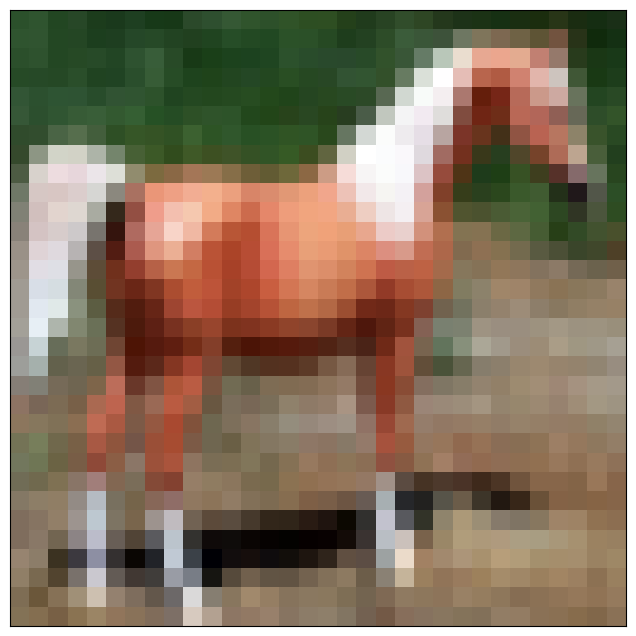

In [13]:
import matplotlib.pyplot as plt

# 원본 이미지
print("image size : {}".format(x_batch[0, ...].shape))
plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.imshow(x_batch[0, ...].permute(1, 2, 0))
plt.show()

원본 이미지가 훈련된 모델을 통과 했을 때 각 합성곱 결과에 대한 Output Feature Map 확인

첫 번째 Feature Map 크기 : torch.Size([1, 32, 32, 32])


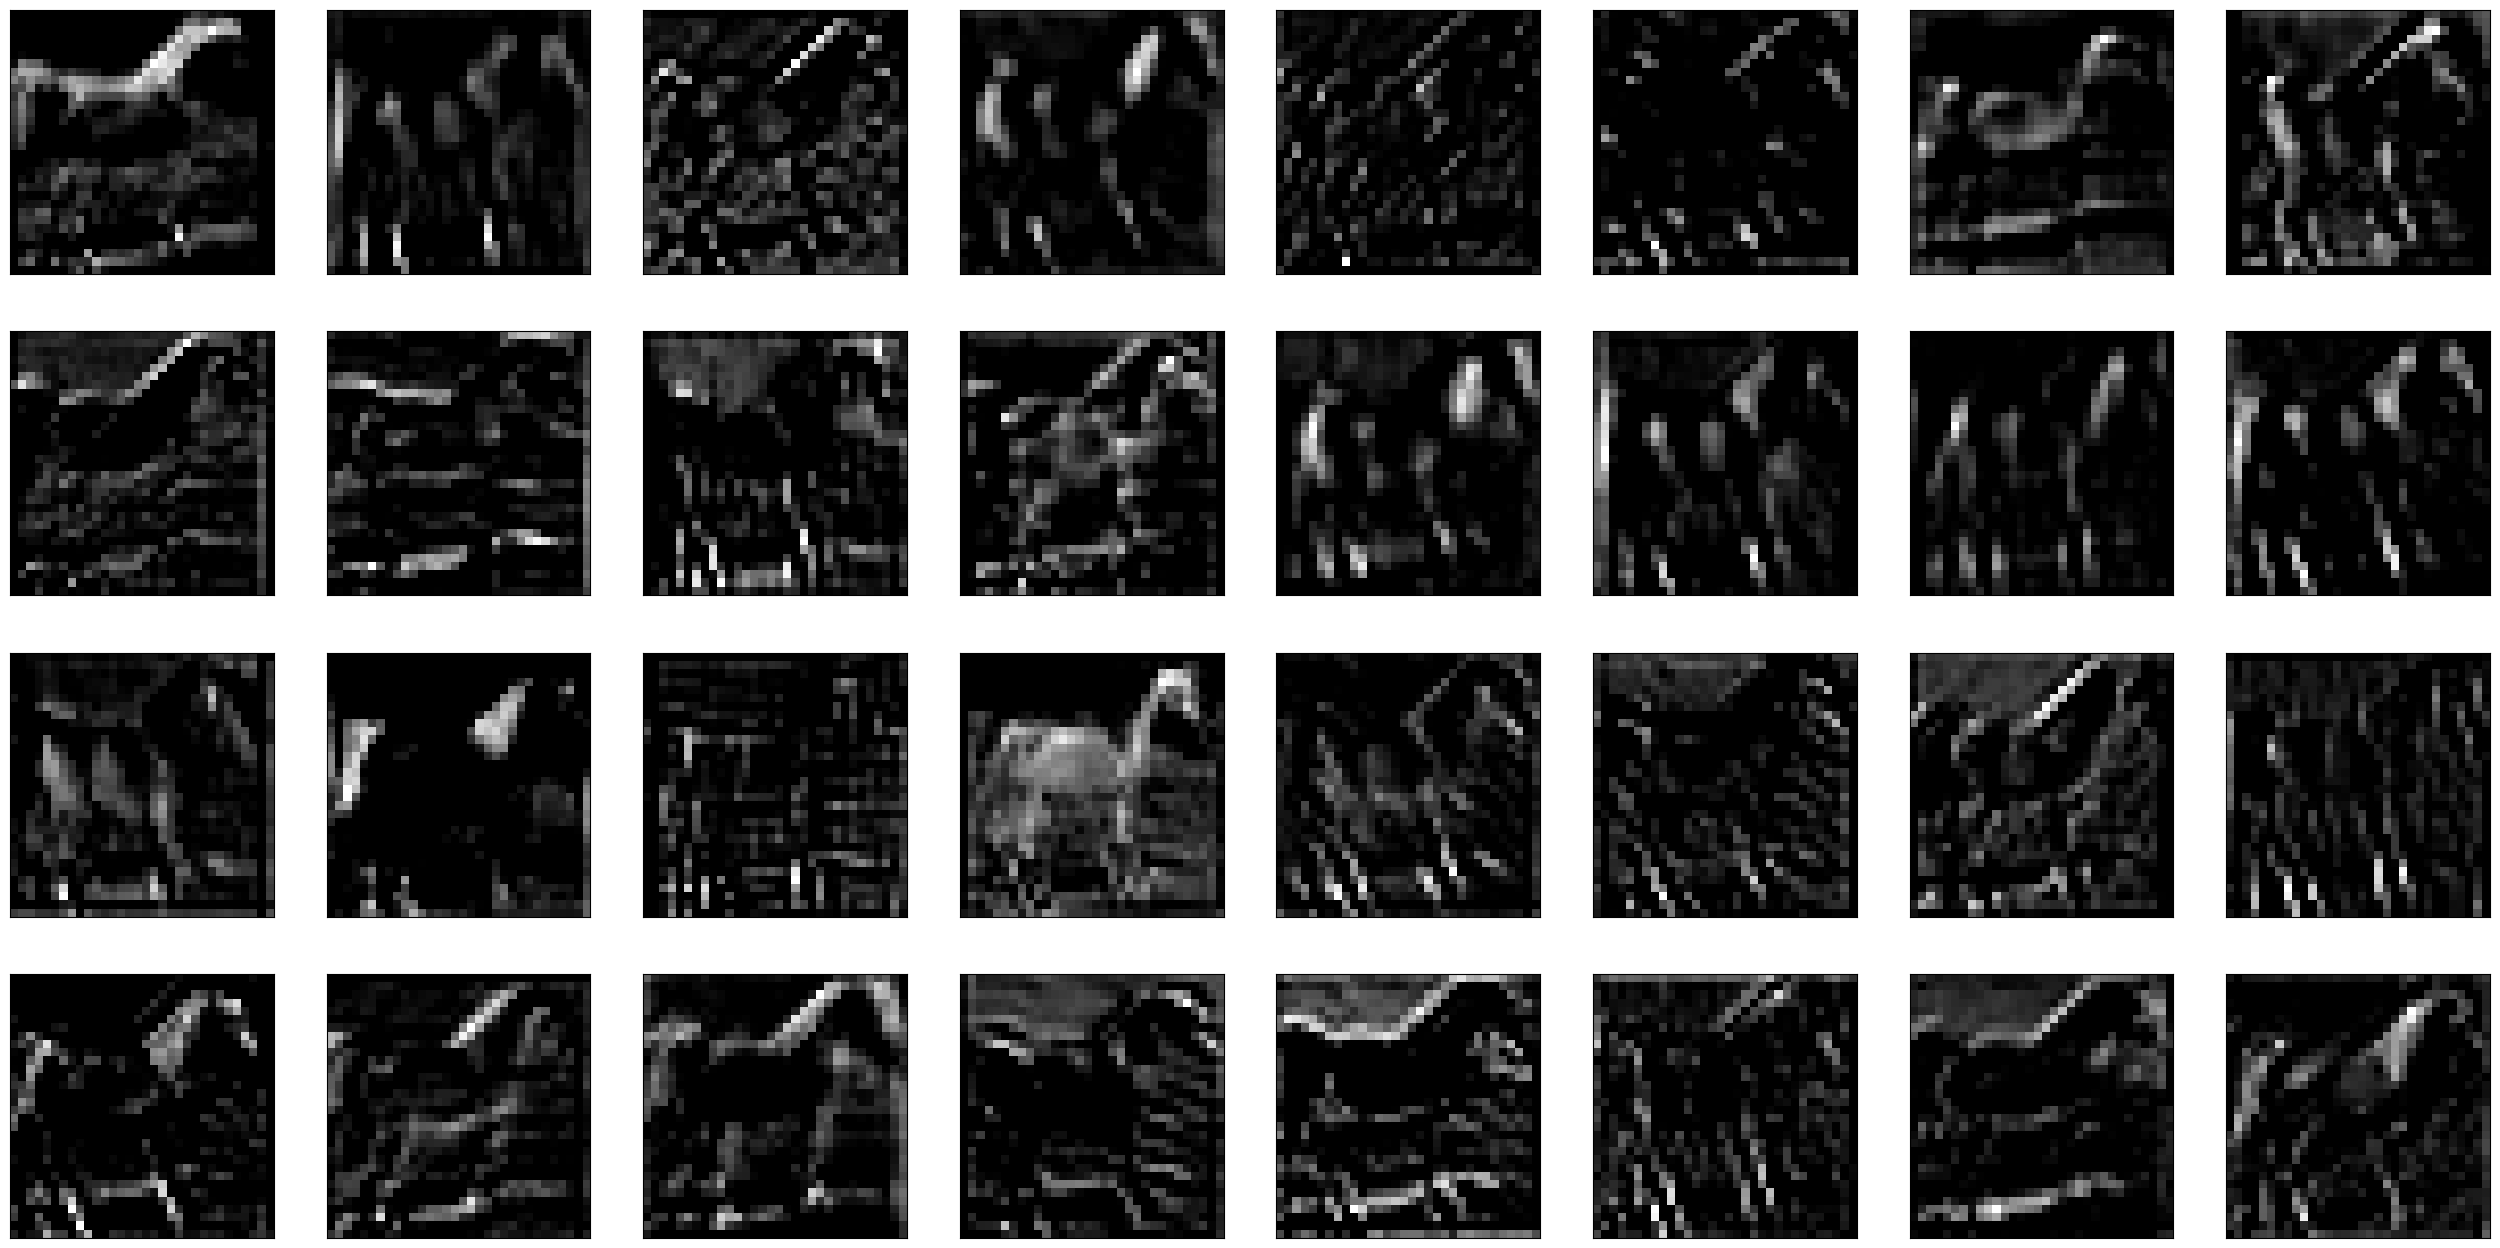

In [14]:
print("첫 번째 Feature Map 크기 : {}".format(feature_map1.shape))
plt.figure(figsize=(32, 16))
for idx in range(32):
    plt.subplot(4, 8, idx + 1, xticks=[], yticks=[])
    plt.imshow(feature_map1[0, idx, ...], cmap="gray")
plt.show()

두 번째 Feature Map 크기 : torch.Size([1, 64, 16, 16])


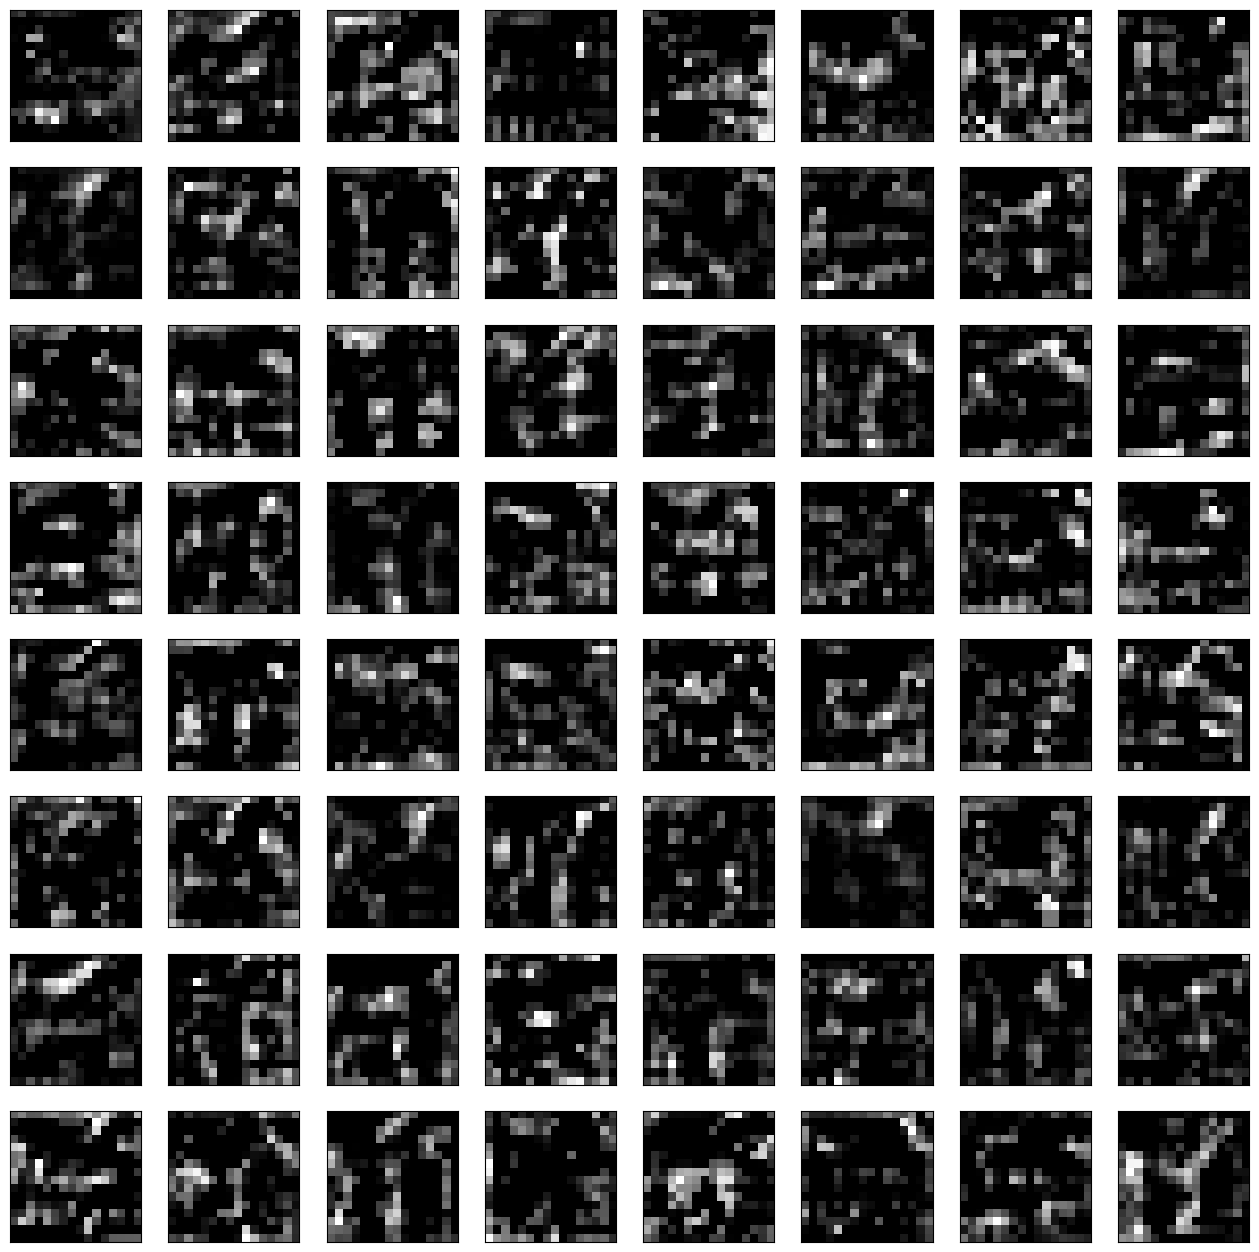

In [15]:
print("두 번째 Feature Map 크기 : {}".format(feature_map2.shape))
plt.figure(figsize=(16, 16))
for idx in range(feature_map2.shape[1]):
    plt.subplot(8, 8, idx + 1, xticks=[], yticks=[])
    plt.imshow(feature_map2[0, idx, ...], cmap="gray")
plt.show()

세 번째 Feature Map 크기 : torch.Size([1, 128, 8, 8])


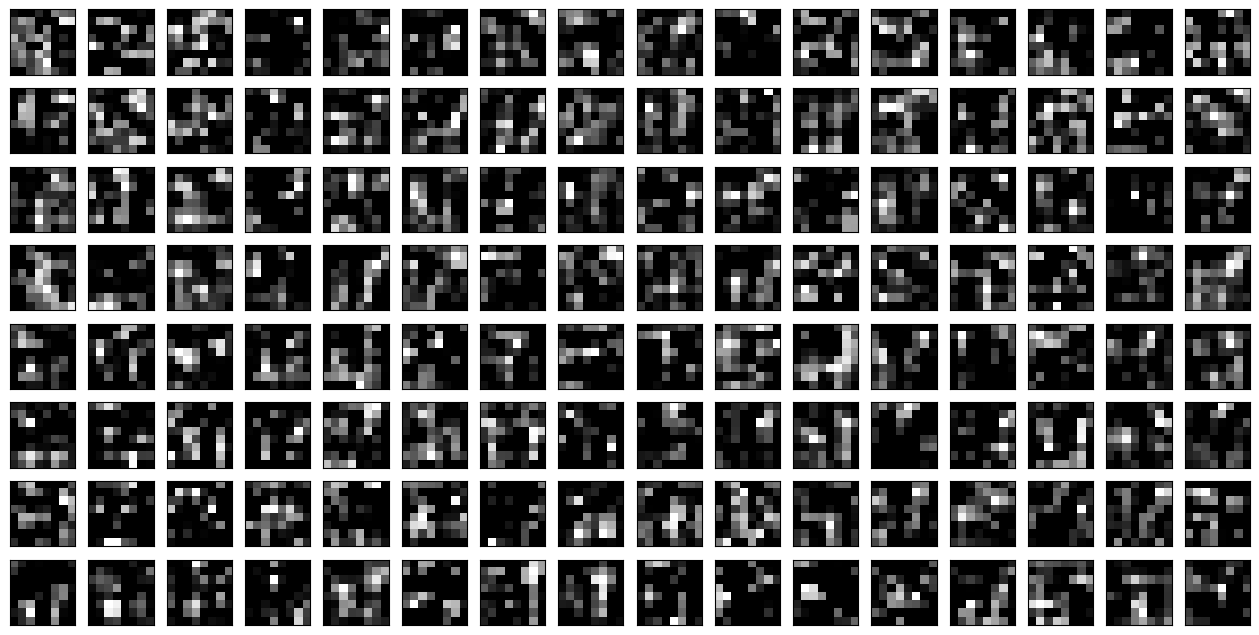

In [16]:
print("세 번째 Feature Map 크기 : {}".format(feature_map3.shape))
plt.figure(figsize=(16, 8))
for idx in range(128):
    plt.subplot(8, 16, idx + 1, xticks=[], yticks=[])
    plt.imshow(feature_map3[0, idx, ...], cmap="gray")
plt.show()

In [17]:
def summarize_feature_map(feature_map):

    summed_map = feature_map.abs().sum(dim=1)
    print("종합된 Feature Map의 크기 : {}".format(summed_map.shape))

    return summed_map

종합된 Feature Map의 크기 : torch.Size([1, 32, 32])


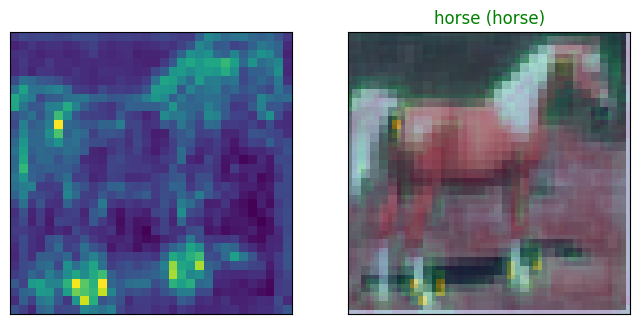

In [18]:
summed_map = summarize_feature_map(feature_map1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(summed_map[0, ...])

plt.subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(x_batch[0, ...].permute(1, 2, 0))
plt.imshow(summed_map[0, ...], extent=[0, 32, 32, 0], alpha=0.4)

pred_class = test_DS.classes[pred]
true_class = test_DS.classes[y_batch]
plt.title(
    f"{pred_class} ({true_class})", color="g" if pred_class == true_class else "r"
)
plt.show()

종합된 Feature Map의 크기 : torch.Size([1, 16, 16])


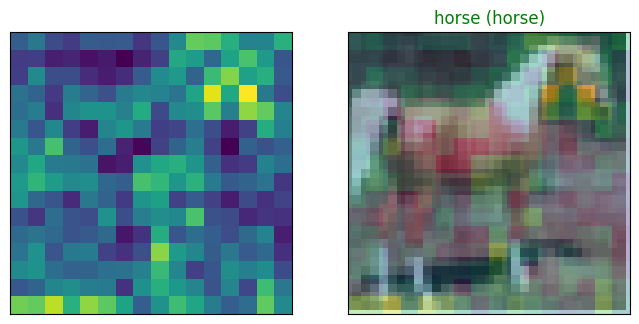

In [19]:
summed_map = summarize_feature_map(feature_map2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(summed_map[0, ...])

plt.subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(x_batch[0, ...].permute(1, 2, 0))
plt.imshow(summed_map[0, ...], extent=[0, 32, 32, 0], alpha=0.4)

pred_class = test_DS.classes[pred]
true_class = test_DS.classes[y_batch]
plt.title(
    f"{pred_class} ({true_class})", color="g" if pred_class == true_class else "r"
)
plt.show()

종합된 Feature Map의 크기 : torch.Size([1, 8, 8])


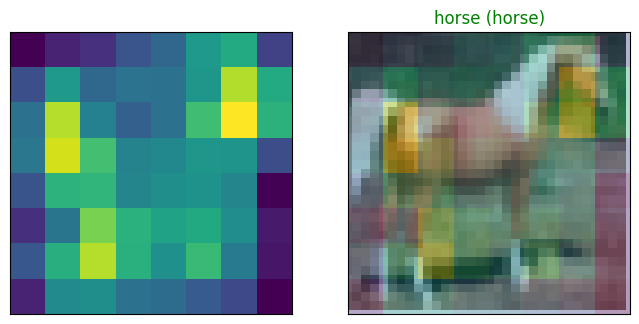

In [20]:
summed_map = summarize_feature_map(feature_map3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(summed_map[0, ...])

plt.subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(x_batch[0, ...].permute(1, 2, 0))
plt.imshow(summed_map[0, ...], extent=[0, 32, 32, 0], alpha=0.4)

pred_class = test_DS.classes[pred]
true_class = test_DS.classes[y_batch]
plt.title(
    f"{pred_class} ({true_class})", color="g" if pred_class == true_class else "r"
)
plt.show()

# 이미지넷 VGG19 모델 불러오기

In [21]:
from torchvision import models

# 1000개의 ImageNet Classification을 하도록 훈련된 VGG19 모델 로딩
load_model = models.vgg19(weights="IMAGENET1K_V1")
print(load_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/leeseungjun/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:08<00:00, 8.34MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [22]:
# 이미지 크기를 조절하기 위한 Transforms
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size=(224, 224)),  # size는 (height,width)
        # transforms.CenterCrop(size=(224,224)), # size 는 (height, width)
    ]
)

In [23]:
CLASS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/DL/CNN/data/imagenet1000_clsidx_to_labels.txt"
with open(CLASS_FILE_PATH) as f:
    idx2label = eval(f.read())  # dictionary로 바꿀 수 있게 eval 사용해서 str -> dict 로
print(idx2label)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/DL/CNN/data/imagenet1000_clsidx_to_labels.txt'

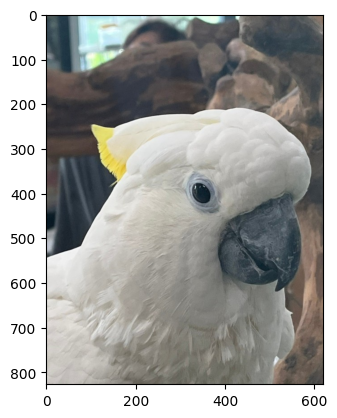

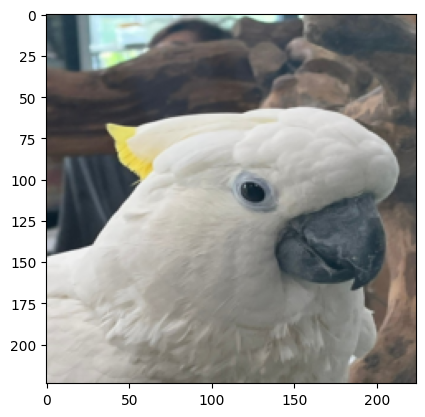

In [ ]:
X = plt.imread("/content/drive/MyDrive/Colab Notebooks/DL/CNN/data/cockatoo.jpg")

# 224 x 224 변환 전 시각화
plt.imshow(X)
plt.show()

# 224 x 224 변환 후 시각화
X = transform(X)
plt.imshow(X.permute(1, 2, 0))

plt.show()

In [ ]:
import torch.nn.functional as F

X = X.unsqueeze(dim=0)
print(X.shape)

load_model.eval()
with torch.no_grad():
    y_hat_sorted = load_model(X).sort(descending=True)
    percent_top5 = F.softmax(y_hat_sorted[0], dim=1)[0, :5] * 100
    # print(percent_top5)
    pred_top5 = y_hat_sorted[1][0, :5]  # sort 하고나서 [1]에 index가 담겨있음
    # print(pred_top5)
for i, idx in enumerate(pred_top5):
    print(idx2label[idx.item()], end="")
    print(f" ({round(percent_top5[i].item(),1)} %)")

torch.Size([1, 3, 224, 224])
plastic bag (77.2 %)
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita (12.5 %)
toilet tissue, toilet paper, bathroom tissue (3.1 %)
ptarmigan (2.8 %)
paper towel (1.9 %)


torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 7, 7])


Text(0.5, 1.0, 'plastic bag')

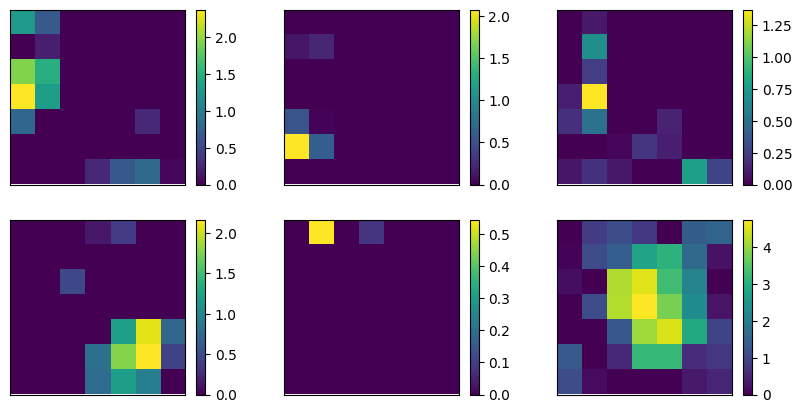

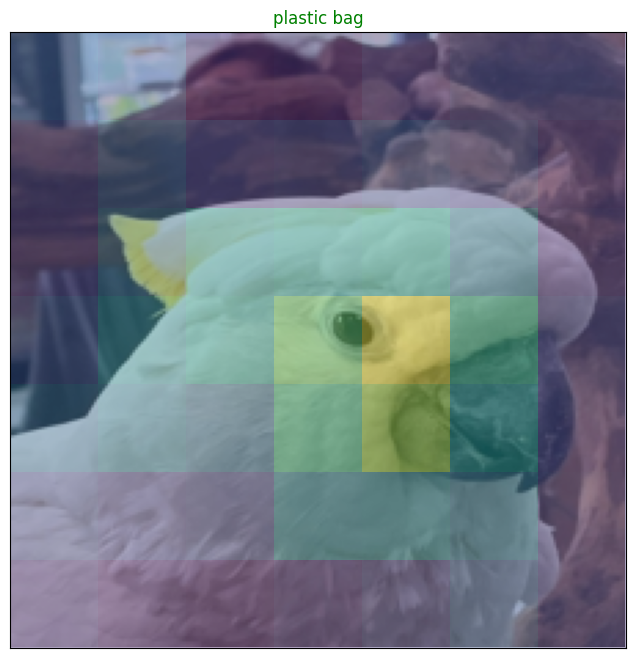

In [ ]:
load_model.eval()
with torch.no_grad():
    X_feature = load_model.features(X)
    print(X_feature.shape)
    X_feature = load_model.avgpool(X_feature).cpu()
    print(X_feature.shape)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1, xticks=[], yticks=[])
    plt.imshow(X_feature[0, i, :, :])
    plt.colorbar()

summed_map = X_feature.sum(dim=1)
plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.imshow(X[0, ...].cpu().permute(1, 2, 0))
plt.imshow(summed_map[0, ...], extent=[0, 224, 224, 0], alpha=0.4)
pred_class = idx2label[pred_top5[0].item()]
plt.title(pred_class, color="g")